### **Цуприков Дмитрий ИУ5-63Б НИР ТМО**

## **Описание набора данных**

В качестве набора данных используется набор, собранный в индийском Национальном институте диабета, заболеваний органов пищеварения и почек - **([Pima Indians Diabetes Database](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database))**. В частности, все пациенты здесь - женщины в возрасте не менее 21 года, родом из племени пима.

Датасет состоит из одного файла **diabetes.csv**

В наборе данных присутствуют следующие столбцы:

*   **Pregnancies**: количество беременностей;
*   **Glucose**: концентрация глюкозы в плазме крови через 2 часа при пероральном тесте на толерантность к глюкозе;
*   **BloodPressure**: диастолическое артериальное давление (мм рт.ст.);
*   **SkinThickness**: толщина кожной складки на трицепсе (мм);
*   **Insulin**: 2-часовая доза сывороточного инсулина (мкме/мл);
*   **BMI**: Индекс массы тела (вес в кг/(рост в м)^2);
*   **DiabetesPedigreeFunction**: наследственная функция диабета;
*   **Age**: возраст в годах;
*   **Outcome**: целевая переменная, где 1 означает, что у пациента был обнаружен сахарный диабет, а 0 - что он не был обнаружен.


Данный датасет использован для решения задачи классификации -  предсказания наличия у пациента сахарного диабета, основываясь на определенных диагностических измерениях, включенных в набор данных.

## **Импорт библиотек и загрузка данных**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, auc

from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset = pd.read_csv('/content/diabetes.csv')

## **Разведочный анализ данных, визуализация и предобработка данных**

### **Общая информация о наборе данных**

In [5]:
dataset.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


Наличие нуля в полях столбцов, исключая Pregnancies и Outcome, свидетельствует о пропусках в исходном наборе данных. Поэтому исключаем столбец Insulin из датасета как столбец с наибольшим количеством пропущенных значений, а пропуски в других колонках (BloodPressure, Glucose, SkinThickness, BMI) заменяем модой.

In [6]:
dataset.drop(columns=['Insulin'], inplace=True)

mode_blood_pressure = dataset[dataset['BloodPressure'] != 0]['BloodPressure'].mode()[0]
mode_glucose = dataset[dataset['Glucose'] != 0]['Glucose'].mode()[0]
mode_skin_thickness = dataset[dataset['SkinThickness'] != 0]['SkinThickness'].mode()[0]
mode_bmi = dataset[dataset['BMI'] != 0]['BMI'].mode()[0]

dataset['BloodPressure'] = dataset['BloodPressure'].replace(0, mode_blood_pressure)
dataset['Glucose'] = dataset['Glucose'].replace(0, mode_glucose)
dataset['SkinThickness'] = dataset['SkinThickness'].replace(0, mode_skin_thickness)
dataset['BMI'] = dataset['BMI'].replace(0, mode_bmi)


In [7]:
dataset.shape

(768, 8)

In [8]:
dataset.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.539062,72.295573,29.994792,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.490660,12.106756,8.886506,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,64.000000,25.000000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,32.000000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   BMI                       768 non-null    float64
 5   DiabetesPedigreeFunction  768 non-null    float64
 6   Age                       768 non-null    int64  
 7   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 48.1 KB


### **Проверка на наличие пропусков**

In [10]:
dataset.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

### **Проверка на наличие дубликатов**

In [11]:
dataset.duplicated().sum()

0

Пропуски и дубликаты в наборе данных отсутствуют; кодирование категориальных признаков проводить незачем, ведь такого типа данных нет в исходном наборе.

## **Визуализация**

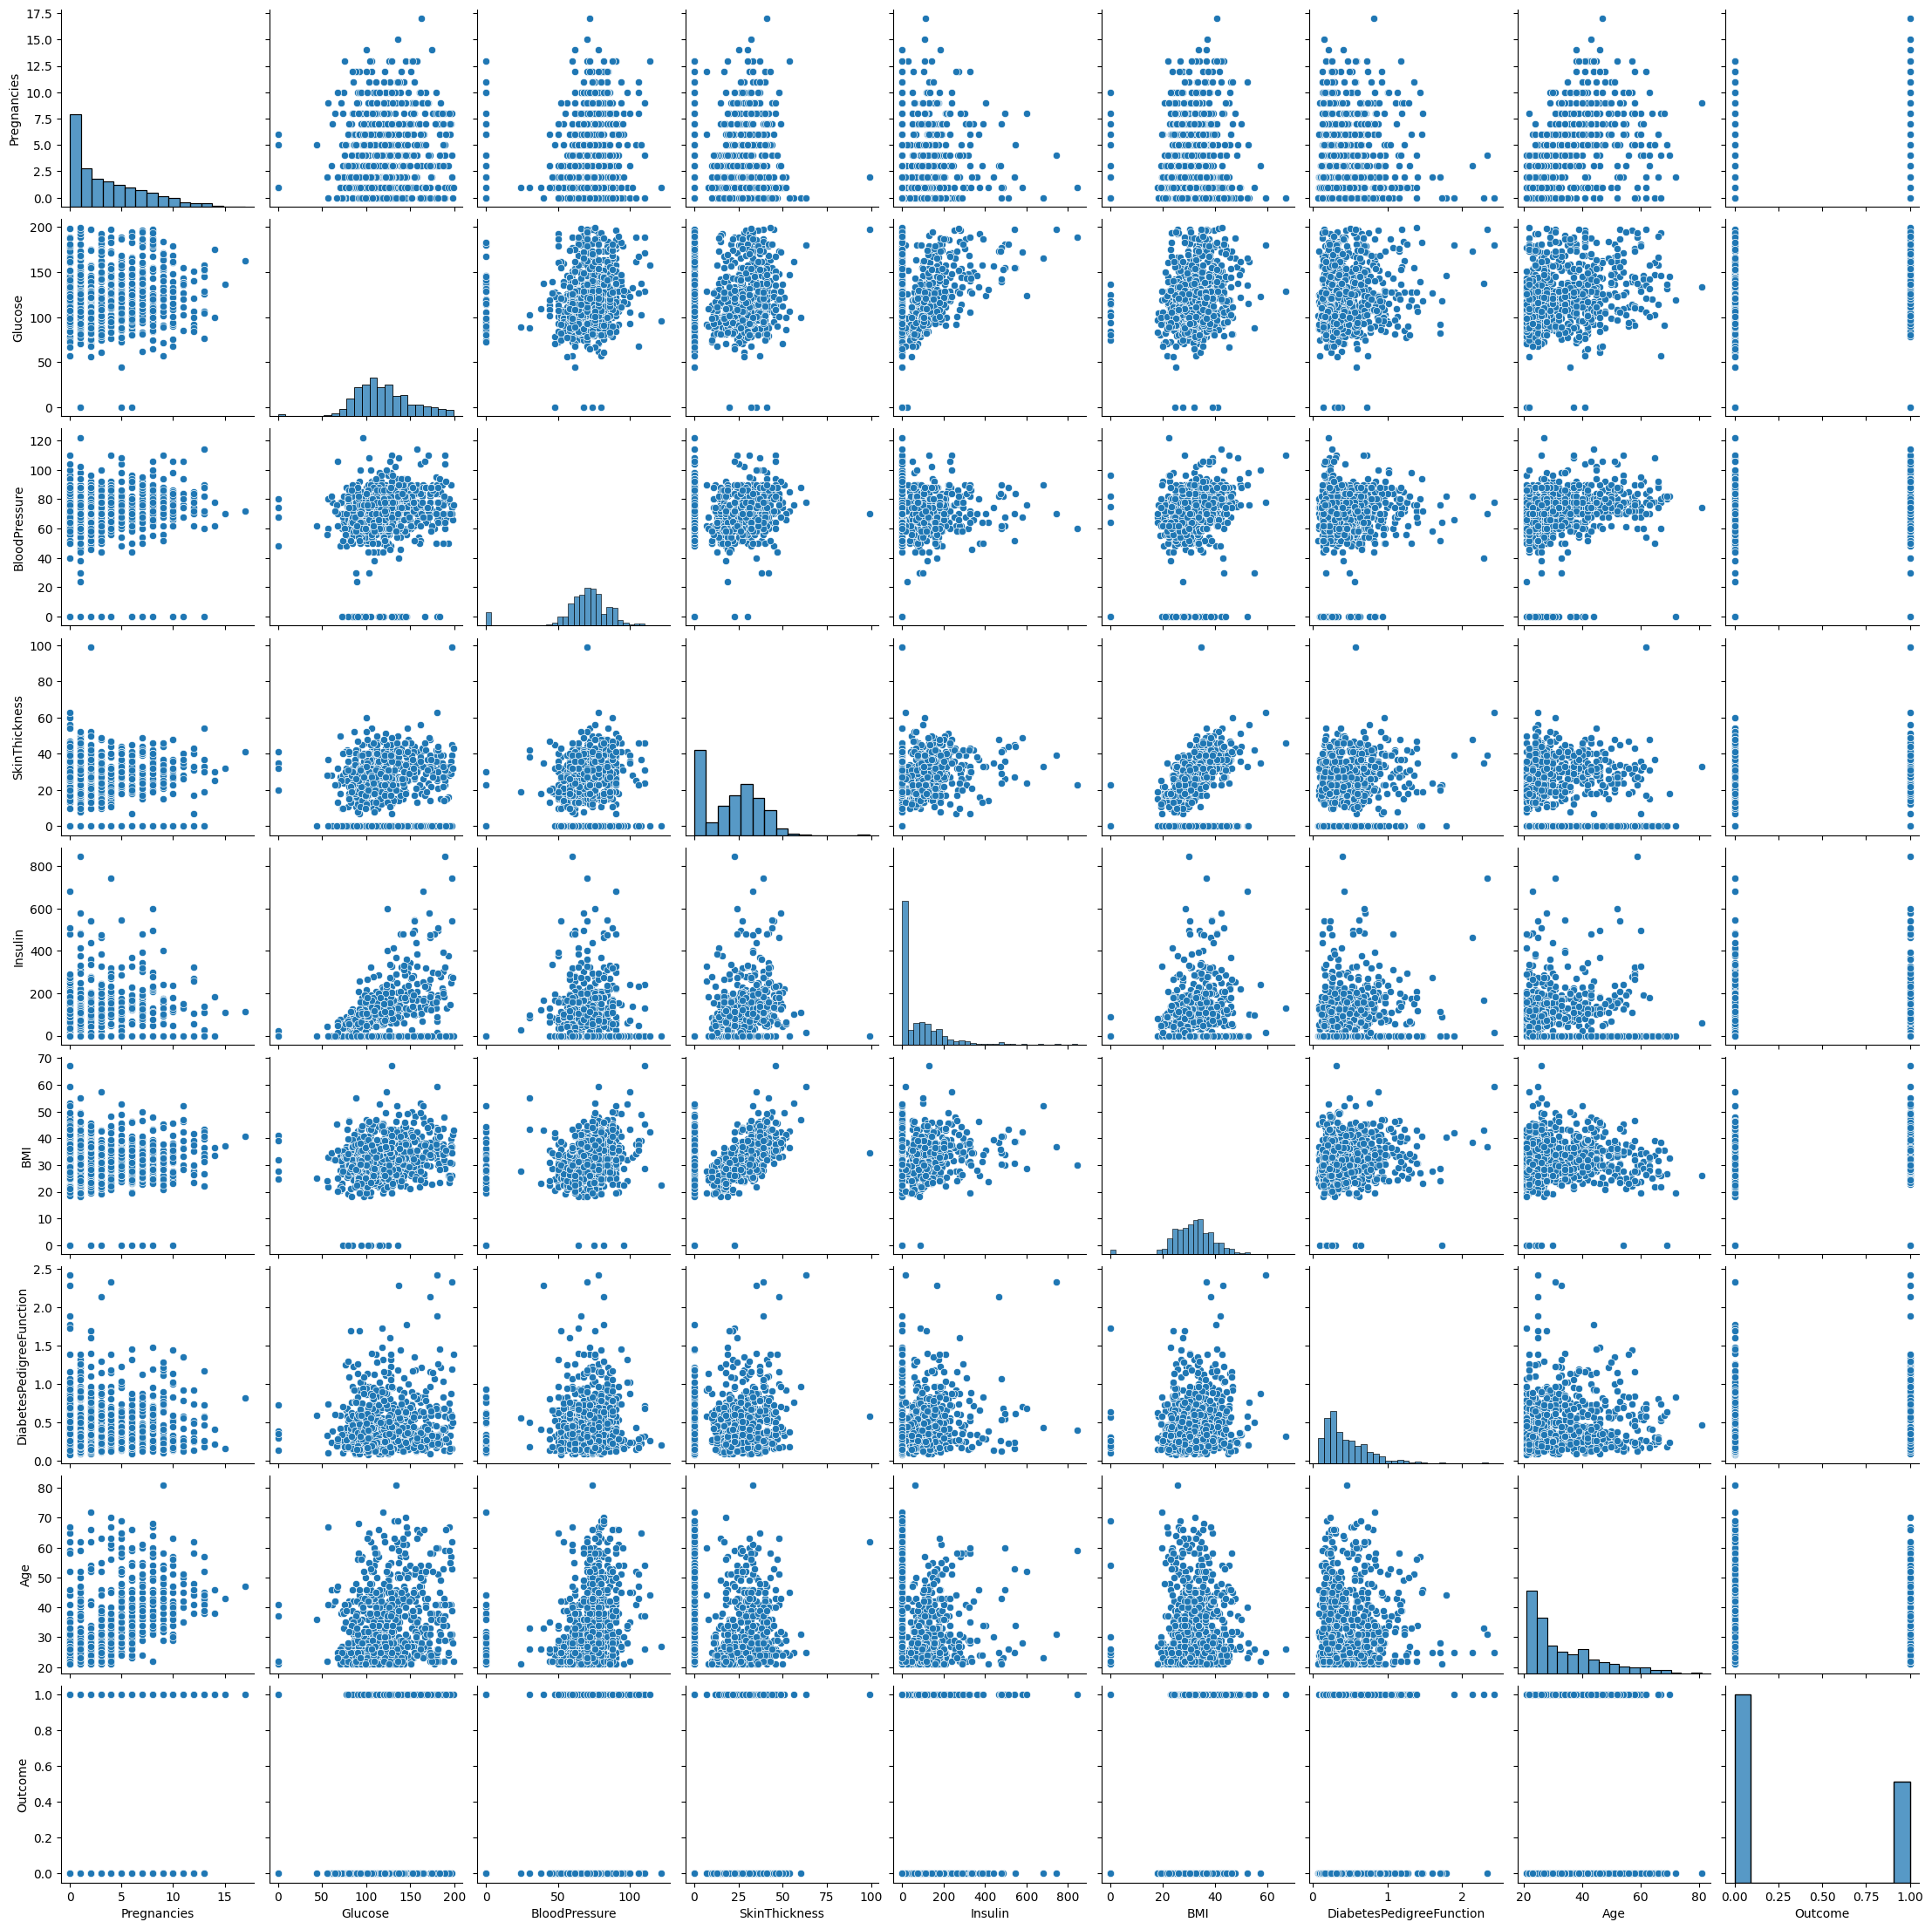

In [ ]:
sns.pairplot(dataset)

In [15]:
# Убедимся, что целевой признак
# для задачи бинарной классификации содержит только 0 и 1
dataset['Outcome'].unique()

array([1, 0])

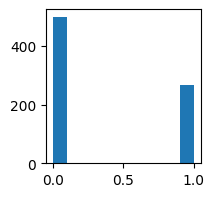

In [12]:
fig, ax = plt.subplots(figsize=(2,2))
plt.hist(dataset['Outcome'])
plt.show()

In [13]:
dataset['Outcome'].value_counts()

Outcome
0    500
1    268
Name: count, dtype: int64

In [14]:
# посчитаем дисбаланс классов
total = dataset.shape[0]
class_0, class_1 = dataset['Outcome'].value_counts()
print('Класс 0 составляет {}%, а класс 1 составляет {}%.'
      .format(round(class_0 / total, 4)*100, round(class_1 / total, 4)*100))

Класс 0 составляет 65.10000000000001%, а класс 1 составляет 34.9%.


**Дисбаланс классов присутствует, но является приемлемым.**

Предположения на основании поиска среднего значения с группировкой по целевому признаку:
*   большее количество беременностей связано с повышенной вероятностью диабета;
*   более высокие уровни концентрации глюкозы в плазме крови связаны с повышенной вероятностью наличия диабета;
*   с нарастанием толщины кожной складки на трицепсе увеличивается предрасположенность к диабету.

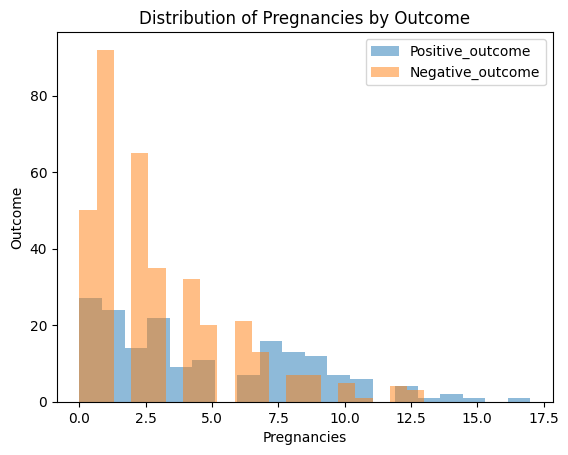

In [ ]:
Positive_outcome = dataset[dataset['Outcome'] == 1]['Pregnancies']
Negative_outcome = dataset[dataset['Outcome'] == 0]['Pregnancies']

plt.hist(Positive_outcome, bins=20, alpha=0.5, label='Positive_outcome')
plt.hist(Negative_outcome, bins=20, alpha=0.5, label='Negative_outcome')

plt.xlabel('Pregnancies')
plt.ylabel('Outcome')
plt.title('Distribution of Pregnancies by Outcome')

plt.legend()

plt.show()

Можно заметить, что чем больше пациент перенес беременностей, тем значимее перевес положительного теста на диабет над отрицательным.

In [ ]:
from scipy.stats import ttest_ind

Positive_outcome = dataset[dataset['Outcome'] == 1]['Pregnancies']
Negative_outcome = dataset[dataset['Outcome'] == 0]['Pregnancies']

t_statistic, p_value = ttest_ind(Positive_outcome, Negative_outcome)
print('t-statistic:', t_statistic)
print('p-value:', p_value)

t-statistic: 6.009826316978722
p-value: 3.4569736448729003e-09


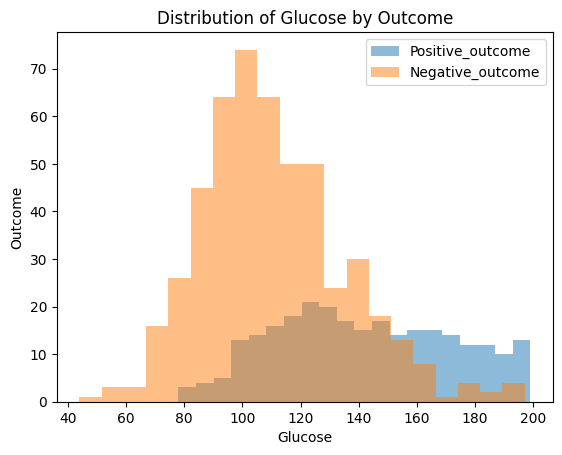

In [ ]:
Positive_outcome = dataset[dataset['Outcome'] == 1]['Glucose']
Negative_outcome = dataset[dataset['Outcome'] == 0]['Glucose']

plt.hist(Positive_outcome, bins=20, alpha=0.5, label='Positive_outcome')
plt.hist(Negative_outcome, bins=20, alpha=0.5, label='Negative_outcome')

plt.xlabel('Glucose')
plt.ylabel('Outcome')
plt.title('Distribution of Glucose by Outcome')

plt.legend()

plt.show()

Можно заметить, что чем выше концентрация глюкозы в плазме крови, тем вероятнее, что у пациента обнаружат диабет.

In [ ]:
from scipy.stats import ttest_ind

Positive_outcome = dataset[dataset['Outcome'] == 1]['Glucose']
Negative_outcome = dataset[dataset['Outcome'] == 0]['Glucose']

t_statistic, p_value = ttest_ind(Positive_outcome, Negative_outcome)
print('t-statistic:', t_statistic)
print('p-value:', p_value)

t-statistic: 13.420160648973402
p-value: 1.4738341999538704e-35


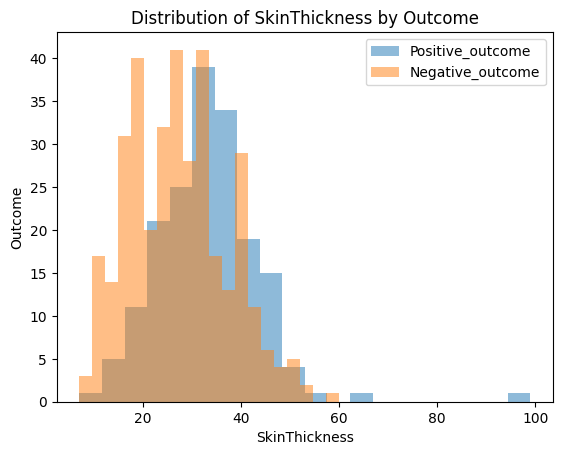

In [ ]:
Positive_outcome = dataset[dataset['Outcome'] == 1]['SkinThickness']
Negative_outcome = dataset[dataset['Outcome'] == 0]['SkinThickness']

plt.hist(Positive_outcome, bins=20, alpha=0.5, label='Positive_outcome')
plt.hist(Negative_outcome, bins=20, alpha=0.5, label='Negative_outcome')

plt.xlabel('SkinThickness')
plt.ylabel('Outcome')
plt.title('Distribution of SkinThickness by Outcome')

plt.legend()

plt.show()

Можно заметить, что люди с положительным тестом на диабет (Positive_outcome) имеют тенденцию к большему диапазону значений толщины кожи, с большей долей в области 30-40 единиц.

In [ ]:
from scipy.stats import ttest_ind

Positive_outcome = dataset[dataset['Outcome'] == 1]['SkinThickness']
Negative_outcome = dataset[dataset['Outcome'] == 0]['SkinThickness']

t_statistic, p_value = ttest_ind(Positive_outcome, Negative_outcome)
print('t-statistic:', t_statistic)
print('p-value:', p_value)

t-statistic: 6.0680342448810745
p-value: 2.466891060091481e-09


## **Масштабирование данных**

In [ ]:
# Числовые колонки для масштабирования
scale_cols = ['SkinThickness', 'Glucose', 'BloodPressure', 'BMI', 'DiabetesPedigreeFunction', 'Age']

sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(dataset[scale_cols])

# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    dataset[new_col_name] = sc1_data[:,i]

In [ ]:
dataset.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,BMI,DiabetesPedigreeFunction,Age,Outcome,SkinThickness_scaled,Glucose_scaled,BloodPressure_scaled,BMI_scaled,DiabetesPedigreeFunction_scaled,Age_scaled
0,6,148,72,35,33.6,0.627,50,1,0.304348,0.643357,0.558140,0.314928,0.232120,0.483333
1,1,85,66,29,26.6,0.351,31,0,0.239130,0.202797,0.488372,0.171779,0.113919,0.166667
3,1,89,66,23,28.1,0.167,21,0,0.173913,0.230769,0.488372,0.202454,0.035118,0.000000
4,0,137,40,35,43.1,2.288,33,1,0.304348,0.566434,0.186047,0.509202,0.943469,0.200000
6,3,78,50,32,31.0,0.248,26,1,0.271739,0.153846,0.302326,0.261759,0.069807,0.083333


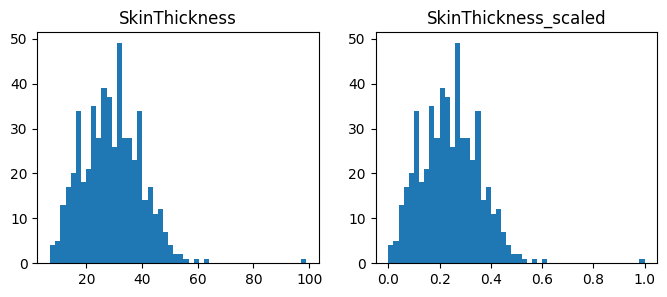

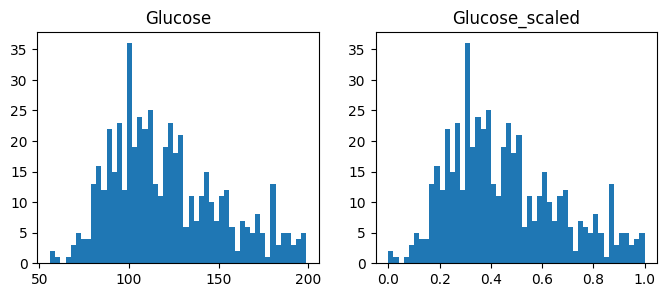

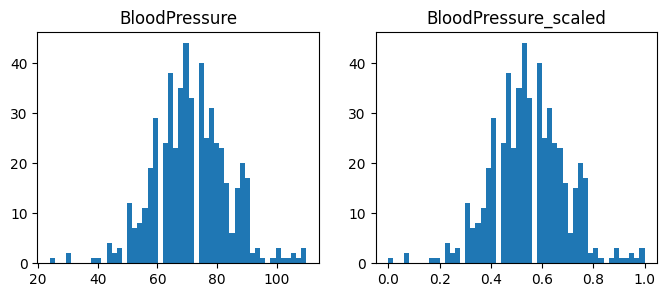

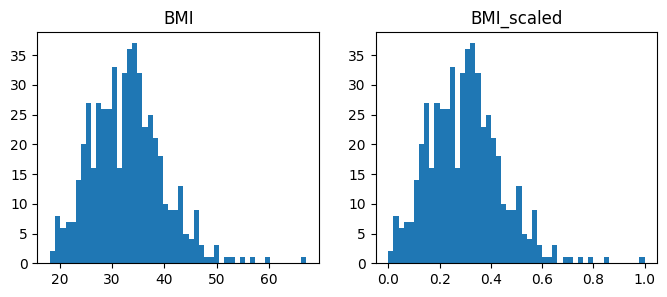

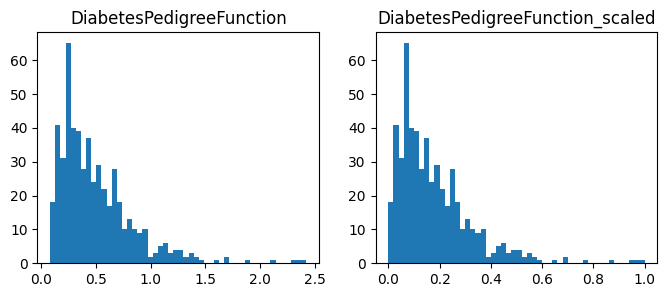

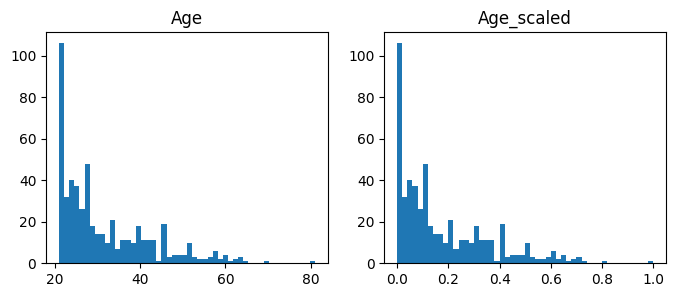

In [ ]:
# Проверим, что масштабирование не повлияло на распределение данных
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(dataset[col], 50)
    ax[1].hist(dataset[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

## **Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения**

In [ ]:
corr_cols_1 = scale_cols + ['Pregnancies', 'Outcome']
corr_cols_1

['SkinThickness',
 'Glucose',
 'BloodPressure',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age',
 'Pregnancies',
 'Outcome']

In [ ]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Pregnancies', 'Outcome']
corr_cols_2

['SkinThickness_scaled',
 'Glucose_scaled',
 'BloodPressure_scaled',
 'BMI_scaled',
 'DiabetesPedigreeFunction_scaled',
 'Age_scaled',
 'Pregnancies',
 'Outcome']

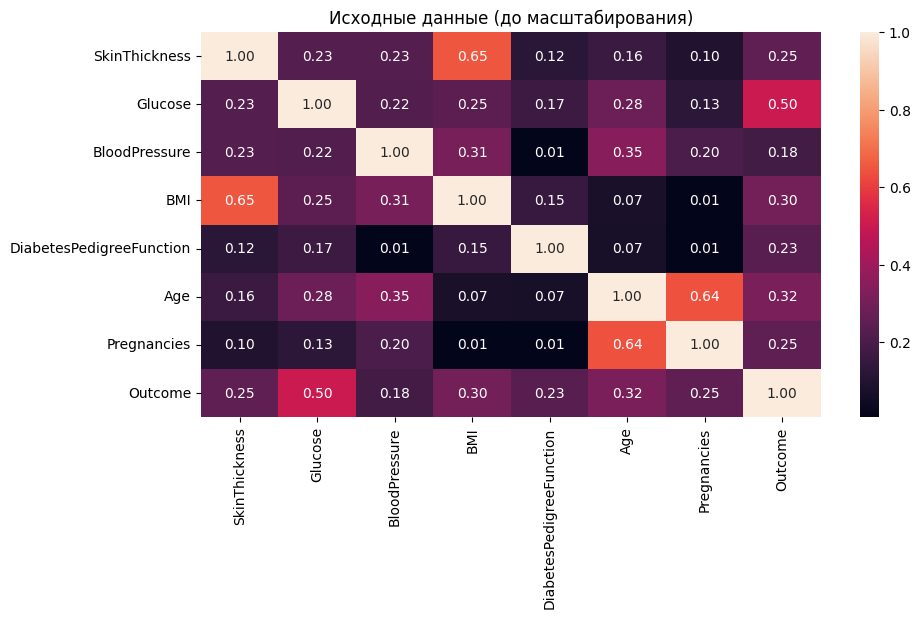

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(dataset[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

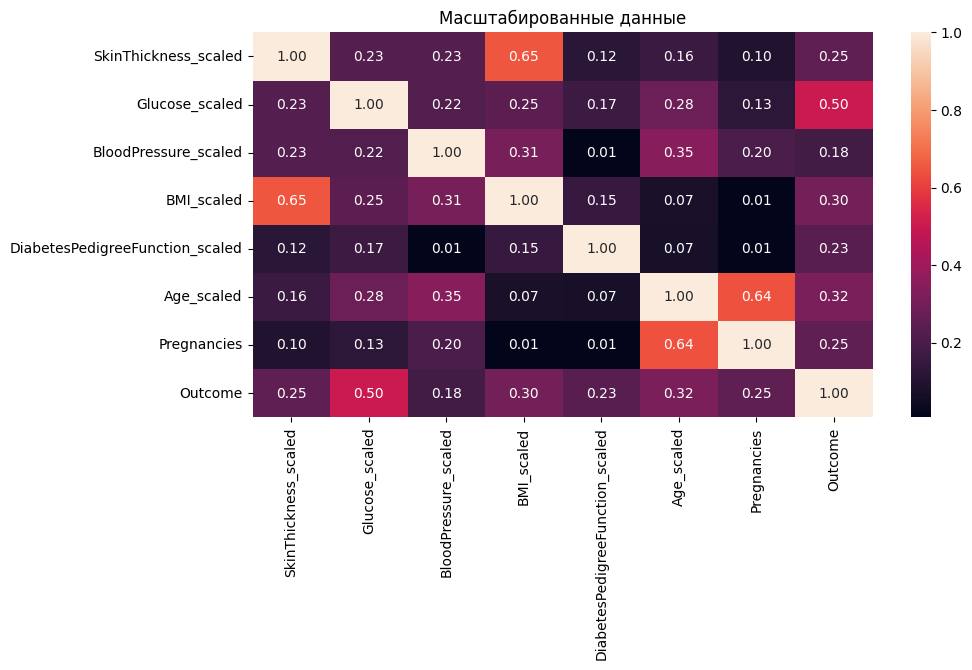

In [ ]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(dataset[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()

На основе корреляционной матрицы можно сделать следующие выводы:

*   Корреляционные матрицы для исходных и масштабированных данных совпадают.
*   Целевой признак классификации "Outcome" наиболее сильно коррелирует с уровнем глюкозы Glucose (0.5) и умеренно коррелирует с признаками Age (0.32) и BMI (0.3). Эти признаки обязательно следует оставить в модели классификации.
*   Признаки Age и Pregnancies (0.64), а также BMI и SkinThickness (0.65) умеренно коррелируют между собой, но так как корелляция не является сильной или очень сильной не будем исключать какой-либо признак пары из набора для построения модели.

In [ ]:
dataset = dataset[['Pregnancies', 'Age_scaled', 'DiabetesPedigreeFunction_scaled', 'BMI_scaled', 'BloodPressure_scaled', 'Glucose_scaled', 'SkinThickness_scaled', 'Outcome']]
dataset.head()

,Pregnancies,Age_scaled,DiabetesPedigreeFunction_scaled,BMI_scaled,BloodPressure_scaled,Glucose_scaled,SkinThickness_scaled,Outcome
0,6,0.483333,0.232120,0.314928,0.558140,0.643357,0.304348,1
1,1,0.166667,0.113919,0.171779,0.488372,0.202797,0.239130,0
3,1,0.000000,0.035118,0.202454,0.488372,0.230769,0.173913,0
4,0,0.200000,0.943469,0.509202,0.186047,0.566434,0.304348,1
6,3,0.083333,0.069807,0.261759,0.302326,0.153846,0.271739,1


## **Выбор метрик для последующей оценки качества моделей**

Выбираем метрики которые учитывают TP:
*   Precision (доля верно предсказанных классификатором положительных объектов, из всех объектов, которые классификатор верно или неверно определил как положительные);
*   Recall (доля верно предсказанных классификатором положительных объектов, из всех действительно положительных объектов);
*   F1-мера (среднее гармоническое precision и recall);
*   ROC AUC (Площадь под кривой: чем ниже проходит кривая, тем меньше ее площадь и тем хуже качество классификатора).

## **Выбор моделей для решения задачи классификации**

Используем следующие модели:

*   KNN;
*   SVC;
*   Дерево решений;
*   Случайный лес;
*   Градиентный бустинг.

## **Формирование обучающей и тестовой выборок на основе исходного набора данных**

In [ ]:
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, -1].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## **Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров**

In [ ]:
from sklearn.metrics import roc_auc_score

def evaluate_models(X_train, X_test, y_train, y_test, models):

    metrics = ['Precision', 'Recall', 'F1-score']

    for model in models:
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        print(f'{model.__class__.__name__}:')
        for i, metric in enumerate(metrics):
            print(f'{metric}: {round([precision, recall, f1][i], 2)}')


        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X_test)[:, 1]
        else:
            y_proba = model.decision_function(X_test)

        print("ROC AUC score:", roc_auc_score(y_test, y_proba))
        fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model.__class__.__name__}: ROC curve')
        plt.legend(loc="lower right")
        plt.show()

In [ ]:
models = [KNeighborsClassifier(n_neighbors=5), SVC(probability=True), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]

KNeighborsClassifier:
Precision: 0.6
Recall: 0.53
F1-score: 0.56
ROC AUC score: 0.7276390008058018


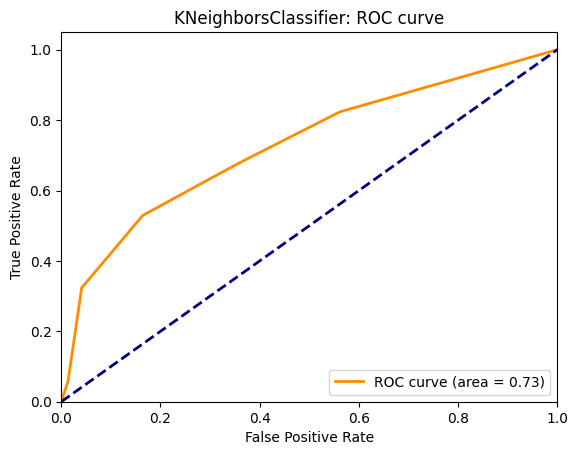

SVC:
Precision: 0.54
Recall: 0.21
F1-score: 0.3
ROC AUC score: 0.7570507655116842


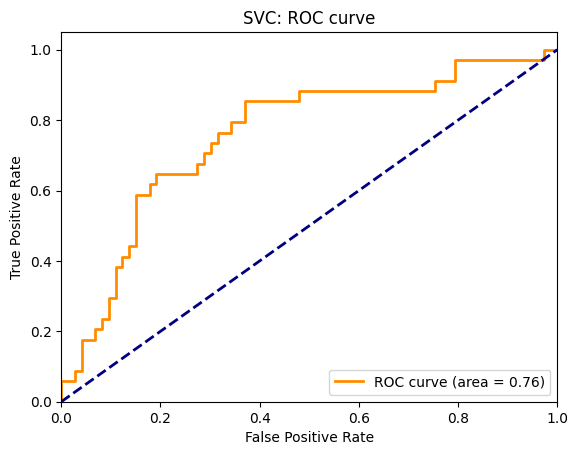

DecisionTreeClassifier:
Precision: 0.59
Recall: 0.5
F1-score: 0.54
ROC AUC score: 0.6678082191780821


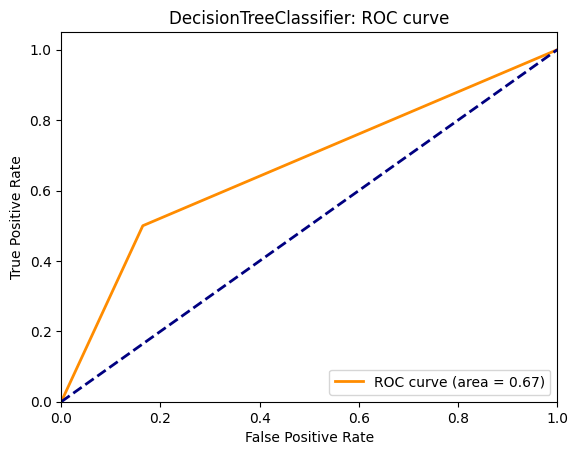

RandomForestClassifier:
Precision: 0.72
Recall: 0.62
F1-score: 0.67
ROC AUC score: 0.8074133763094279


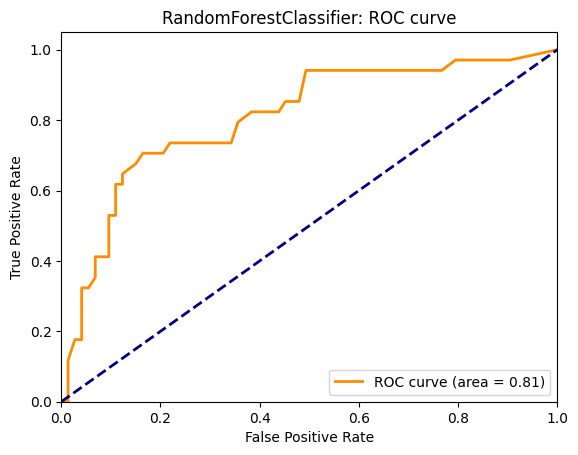

GradientBoostingClassifier:
Precision: 0.67
Recall: 0.59
F1-score: 0.62
ROC AUC score: 0.8094278807413376


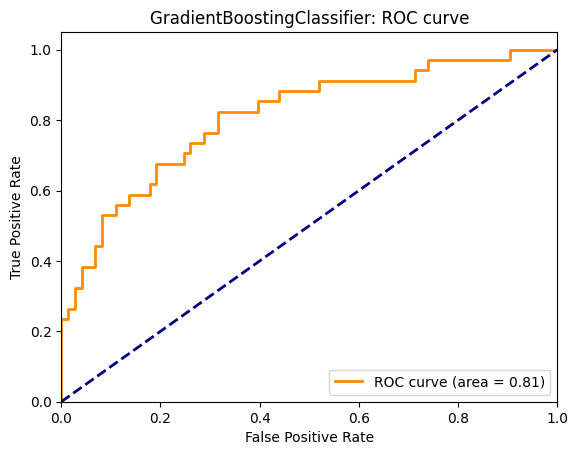

In [ ]:
evaluate_models(X_train, X_test, y_train, y_test, models)

## **Подбор гиперпараметров для выбранных моделей.**

In [ ]:
knn_model = KNeighborsClassifier()
param_grid = {'n_neighbors': [7,8,9],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_search = GridSearchCV(knn_model, param_grid, cv=5, scoring='precision')
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'uniform'}
Best score: 0.7027056277056276


In [ ]:
best_knn_model = KNeighborsClassifier(**grid_search.best_params_)
best_knn_model

KNeighborsClassifier(n_neighbors=8)

In [ ]:
svc_model = SVC()
param_grid = {'C': [1],
              'kernel': ['linear', 'rbf'],
              'degree': [4],
              'gamma': ['scale']}

grid_search = GridSearchCV(svc_model, param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'C': 1, 'degree': 4, 'gamma': 'scale', 'kernel': 'linear'}
Best score: 0.7741317883661306


In [ ]:
best_svc_model = SVC(**grid_search.best_params_, probability=True)
best_svc_model

SVC(C=1, degree=4, kernel='linear', probability=True)

In [ ]:
tree_model = DecisionTreeClassifier()
param_grid = {'criterion': ['gini', 'entropy'],
              'max_depth': [3, 5, 7, 9, None],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', 'log2', None]}

grid_search = GridSearchCV(tree_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best score: 0.7905882352941177


In [ ]:
best_tree_model = DecisionTreeClassifier(**grid_search.best_params_)
best_tree_model

DecisionTreeClassifier(max_depth=5, min_samples_split=10)

In [ ]:
rf_model = RandomForestClassifier()
param_grid = {'n_estimators': [100],
              'max_depth': [5, None],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2],
              'max_features': ['sqrt', None]}

grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best score: 0.7905882352941177


In [ ]:
best_rf_model = RandomForestClassifier(**grid_search.best_params_)
best_rf_model

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5)

In [ ]:
gb_model = GradientBoostingClassifier()
param_grid = {'learning_rate': [0.1, 0.2],
              'max_depth': [3, 5],
              'min_samples_split': [2, 5],
              'min_samples_leaf': [1, 2, 4],
              'max_features': ['sqrt', None]}

grid_search = GridSearchCV(gb_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print('Best hyperparameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best score: 0.7976470588235294


In [ ]:
best_gb_model = GradientBoostingClassifier(**grid_search.best_params_)
best_gb_model

GradientBoostingClassifier(max_features='sqrt')

## **Построение с найденными оптимальными значениями гиперпараметров**

In [ ]:
opt_models = [ best_knn_model, best_svc_model, best_tree_model, best_rf_model, best_gb_model]

KNeighborsClassifier:
Precision: 0.77
Recall: 0.5
F1-score: 0.61
ROC AUC score: 0.7489927477840451


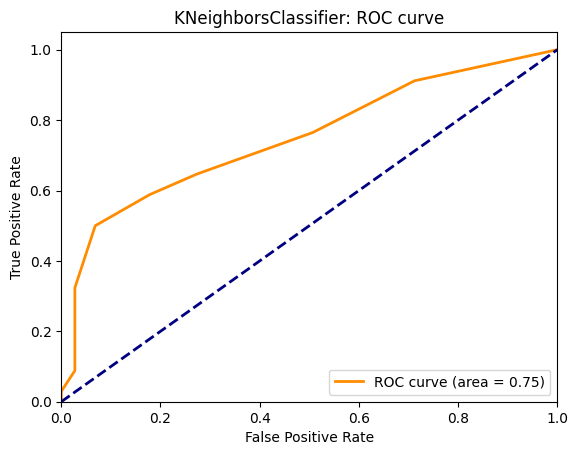

SVC:
Precision: 0.73
Recall: 0.56
F1-score: 0.63
ROC AUC score: 0.8122481869460113


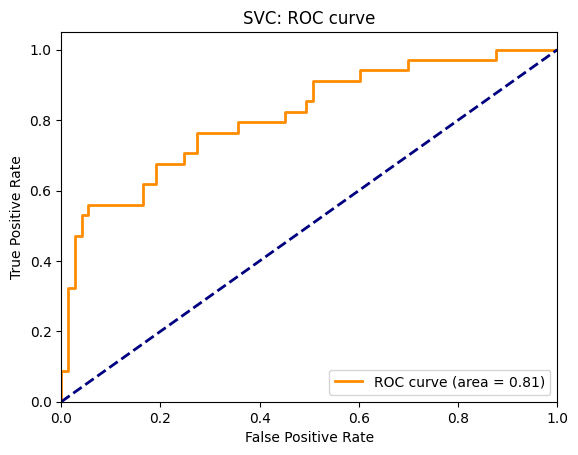

DecisionTreeClassifier:
Precision: 0.59
Recall: 0.59
F1-score: 0.59
ROC AUC score: 0.7485898468976632


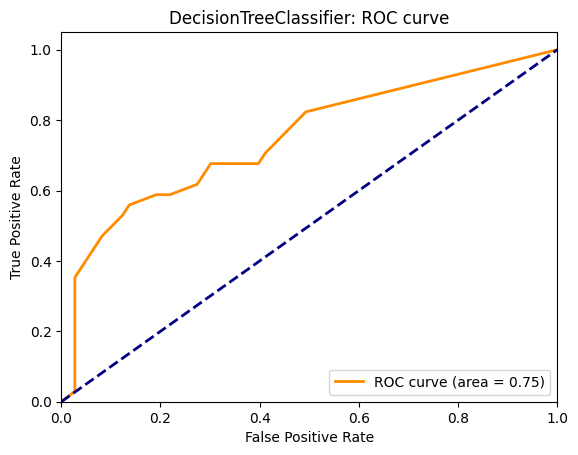

RandomForestClassifier:
Precision: 0.68
Recall: 0.62
F1-score: 0.65
ROC AUC score: 0.8130539887187752


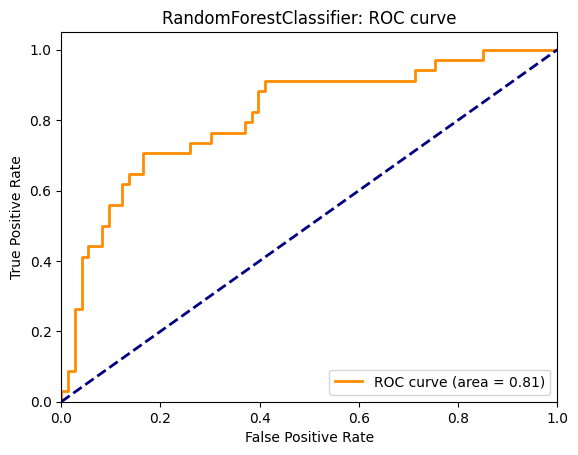

GradientBoostingClassifier:
Precision: 0.64
Recall: 0.53
F1-score: 0.58
ROC AUC score: 0.8211120064464141


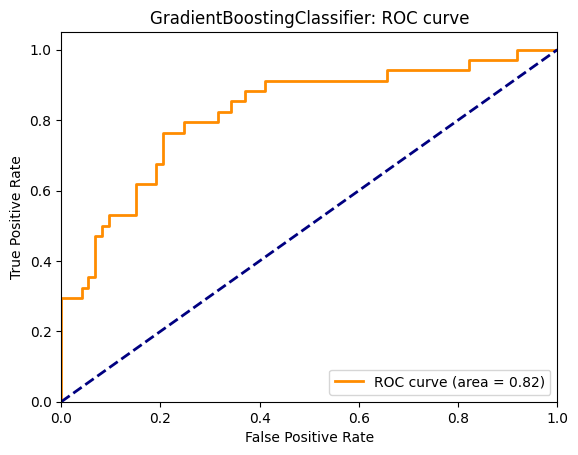

In [ ]:
evaluate_models(X_train, X_test, y_train, y_test, opt_models)

Модели-лидеры в метрках:
*   Precision - KNeighborsClassifier
*   Recall - RandomForestClassifier;
*   F1 score - RandomForestClassifier;
*   ROC AUC score - GradientBoostingClassifier.





**Вывод: на основании двух метрик из четырех используемых, лучшей оказалась модель случайного леса.**